In [1]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import datetime

### Loading the initial dataset

In [2]:
path = os.getcwd() + '/../dataset/anonymized_dataset_for_ADM2017/'
print(path + 'student_log_{}.csv'.format(1))
log1 = pd.read_csv(path + 'student_log_{}.csv'.format(1))
initial_col_order = [col.lower() for col in list(log1.columns)]

data = pd.DataFrame()
for i in range(1, 10):
    student_log = pd.read_csv(path + 'student_log_{}.csv'.format(i))
    student_log.columns = [col.lower() for col in student_log]
    data = pd.concat([data, student_log], ignore_index=True)

# reorder everything with the original order, where student id is in the first column
data = data[initial_col_order]
data.shape
data.head()

/Users/yeldosbalgabekov/Desktop/Books and Schools/UoSouthampton/Data Mining/DataMining/Yeldos_Richa/../dataset/anonymized_dataset_for_ADM2017/student_log_1.csv


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (74,75) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,itest_id,sy assistments usage,aveknow,avecarelessness,avecorrect,numactions,averesbored,averesengcon,averesconf,averesfrust,...,confidence(off task),confidence(gaming),res_bored,res_concentrating,res_confused,res_frustrated,res_offtask,res_gaming,ln-1,ln
0,8,2004-2005,0.352416,0.183276,0.483902,1056,0.208389,0.679126,0.115905,0.112408,...,0.838710,0.008522,0.376427,0.320317,0.000000,0.0,0.785585,0.000264,0.13,0.0611904
1,8,2004-2005,0.352416,0.183276,0.483902,1056,0.208389,0.679126,0.115905,0.112408,...,0.600000,0.047821,0.156027,0.995053,0.887452,0.0,0.468252,0.001483,0.0611904,0.21351
2,8,2004-2005,0.352416,0.183276,0.483902,1056,0.208389,0.679126,0.115905,0.112408,...,0.600000,0.047821,0.156027,0.995053,0.887452,0.0,0.468252,0.001483,0.116,0.0333058
3,8,2004-2005,0.352416,0.183276,0.483902,1056,0.208389,0.679126,0.115905,0.112408,...,0.204082,0.343996,0.156027,0.744520,0.000000,0.0,0.108417,0.010665,0.116,0.0333058
4,8,2004-2005,0.352416,0.183276,0.483902,1056,0.208389,0.679126,0.115905,0.112408,...,0.204082,0.343996,0.156027,0.744520,0.000000,0.0,0.108417,0.010665,0.0333058,0.118386


### Transforming the initial dataset and loading Training Set

In [176]:
def to_float(x):
    try:
        if x.isdigit():
            return float(x)
    except:
        if x == '.':
            return 0
        return x

def series_types(series):
    types = []
    for i in set(series):
        if not type(i) in types:
            types.append(type(i))
    return(types)


data['sy assistments usage'] = data['sy assistments usage'].astype('category')
data['skill'] = data['skill'].astype('category')
data['problemtype'] = data['problemtype'].astype('category')
data['ln-1'] = data['ln-1'].apply(lambda x: to_float(x))
data['ln'] = data['ln'].apply(lambda x: to_float(x))
# data.memory_usage(deep=True)
# data.info(memory_usage='deep')

training = pd.read_csv(path + 'training_label.csv').drop(['AveCorrect'], axis=1)
training.columns = [col.lower() for col in training.columns]
training = training.drop_duplicates()
training.shape

# merged data set with isSTEM
df = data.merge(training, on='itest_id', how="left")
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 626548 entries, 0 to 626547
Data columns (total 79 columns):
itest_id                                  626548 non-null int64
sy assistments usage                      626548 non-null object
aveknow                                   626548 non-null float64
avecarelessness                           626548 non-null float64
avecorrect                                626548 non-null float64
numactions                                626548 non-null int64
averesbored                               626548 non-null float64
averesengcon                              626548 non-null float64
averesconf                                626548 non-null float64
averesfrust                               626548 non-null float64
averesofftask                             626548 non-null float64
averesgaming                              626548 non-null float64
actionid                                  626548 non-null int64
skill                                 

### Filtering for the actions of the "training" students

In [4]:
actions = df[df.isstem.notnull()]
actions['skill'] = actions.skill.astype('category')
print("training set size: ", training.shape[0], "actions for # of students: ", len(actions.itest_id.unique()))
print("sample size useless for training: ", training.shape[0] - len(actions.itest_id.unique()))

# merged training data set
stem = actions[actions.isstem == 1]
nonstem = actions[actions.isstem == 0]

actions.head()

training set size:  514 actions for # of students:  326
sample size useless for training:  188


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,itest_id,sy assistments usage,aveknow,avecarelessness,avecorrect,numactions,averesbored,averesengcon,averesconf,averesfrust,...,res_concentrating,res_confused,res_frustrated,res_offtask,res_gaming,ln-1,ln,schoolid,mcas,isstem
1056,35,2004-2005,0.255164,0.158848,0.379658,993,0.222796,0.650079,0.069987,0.164347,...,0.262675,0.060808,0.000000,0.889219,0.005797,0.271000,0.077899,2.0,34.0,0.0
1057,35,2004-2005,0.255164,0.158848,0.379658,993,0.222796,0.650079,0.069987,0.164347,...,0.696486,0.000000,0.009561,0.108417,0.001483,0.077899,0.225856,2.0,34.0,0.0
1058,35,2004-2005,0.255164,0.158848,0.379658,993,0.222796,0.650079,0.069987,0.164347,...,0.580763,0.000000,0.009561,0.108417,0.003940,0.225856,0.483008,2.0,34.0,0.0
1059,35,2004-2005,0.255164,0.158848,0.379658,993,0.222796,0.650079,0.069987,0.164347,...,0.580763,0.000000,0.009561,0.108417,0.003940,0.483008,0.745290,2.0,34.0,0.0
1060,35,2004-2005,0.255164,0.158848,0.379658,993,0.222796,0.650079,0.069987,0.164347,...,0.898073,0.000000,0.009561,0.468252,0.001483,0.745290,0.900994,2.0,34.0,0.0


### Testing the cases
Top Skill Accuracy

#### Creating temporary subset removing unnecessary data

In [35]:
# filtering for the necessary col
tmp = actions[['itest_id', 'skill','correct']]
# covnverting sk# create a table of correctness by question (from actions_table to problems_table)ills into cat type
tmp['skill'] = tmp.skill.astype('category').cat.codes
tmp['total'] = tmp.skill.apply(lambda x: 1)
tmp.head()


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,itest_id,skill,correct,total
1056,35,56,0,1
1057,35,56,1,1
1058,35,56,1,1
1059,35,56,1,1
1060,35,56,1,1


#### Create a table of correctness by action

In [37]:
student_accuracy = tmp.groupby(['itest_id', 'skill'], as_index=False).sum()
student_accuracy['accuracy'] = student_accuracy.correct / student_accuracy.total
print(student_accuracy.shape)
student_accuracy.head()

(13731, 5)


,itest_id,skill,correct,total,accuracy
0,35,1,13,19,0.684211
1,35,3,1,2,0.500000
2,35,4,1,5,0.200000
3,35,5,6,19,0.315789
4,35,8,1,4,0.250000


#### Visual Understanding of the overall student behaviour by skills using BoxPlot

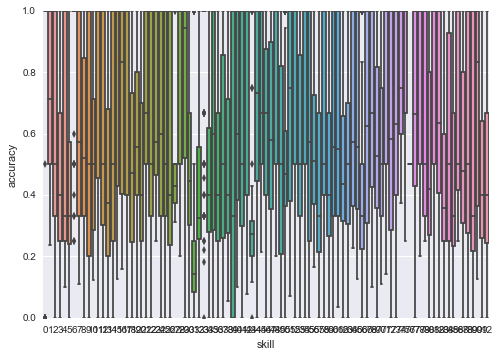

(<matplotlib.axes._subplots.AxesSubplot at 0x11d007080>, None)

In [39]:
sns.boxplot(student_accuracy.skill, student_accuracy.accuracy), plt.show()

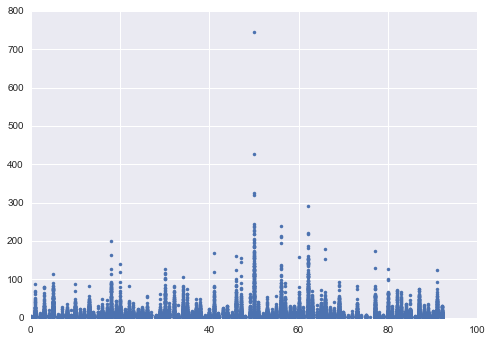

([<matplotlib.lines.Line2D at 0x11e07edd8>], None)

In [40]:
plt.plot(student_accuracy.skill, student_accuracy.total, '.'), plt.show()

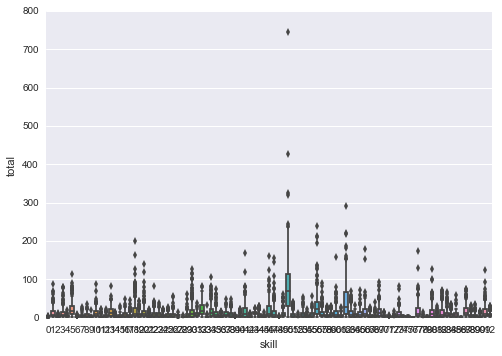

(<matplotlib.axes._subplots.AxesSubplot at 0x11e05b2b0>, None)

In [41]:
sns.boxplot(student_accuracy.skill, student_accuracy.total), plt.show()

#### Retreiving isStem data to the table

In [42]:
student_accuracy_with_stem = student_accuracy.merge(training[['itest_id', 'isstem']], on='itest_id')
stem_accuracy = student_accuracy_with_stem[student_accuracy_with_stem.isstem==1]
non_stem_accuracy = student_accuracy_with_stem[student_accuracy_with_stem.isstem==0]
stem_accuracy.shape, non_stem_accuracy.shape
non_stem_accuracy[non_stem_accuracy.skill==0]

,itest_id,skill,correct,total,accuracy,isstem
744,739,0,1,1,1.0,0
1553,922,0,1,1,1.0,0
2860,1551,0,3,3,1.0,0
2991,1598,0,1,1,1.0,0
3668,1892,0,0,1,0.0,0
3911,2156,0,0,1,0.0,0
4015,2370,0,1,1,1.0,0
4477,2839,0,1,1,1.0,0
4824,3159,0,1,1,1.0,0
5059,3206,0,1,1,1.0,0


#### Calculating the difference average

In [43]:
average_accuracy_with_stem = student_accuracy_with_stem.groupby(['isstem', 'skill'], as_index=False).mean()
average_accuracy_with_stem = average_accuracy_with_stem.drop(['itest_id'], axis=1)
average_accuracy_with_stem.head()

,isstem,skill,correct,total,accuracy
0,0,0,0.911765,1.117647,0.794118
1,0,1,7.371681,13.787611,0.704015
2,0,2,1.068182,2.659091,0.550071
3,0,3,3.466667,12.090909,0.461597
4,0,4,1.211538,3.519231,0.495346


#### Correlation Heatmap

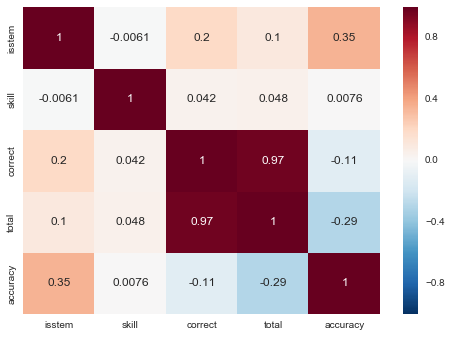

(<matplotlib.axes._subplots.AxesSubplot at 0x1224f5ba8>, None)

In [44]:
sns.heatmap(average_accuracy_with_stem.corr(), annot=True), plt.show()

92 93 185


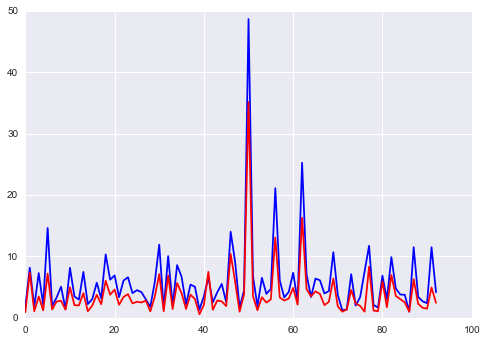

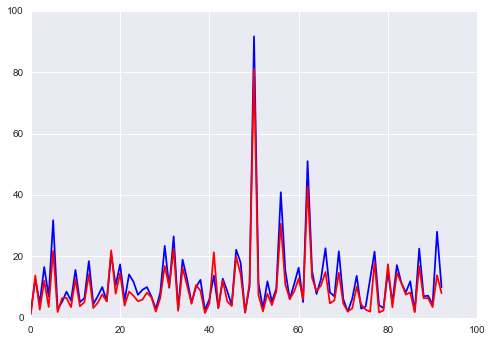

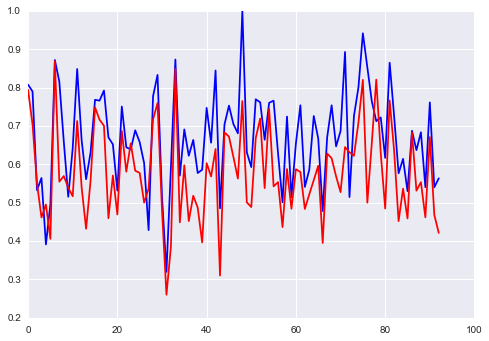

([<matplotlib.lines.Line2D at 0x10bdbc860>,
 None)

In [45]:
stem_ave = average_accuracy_with_stem[average_accuracy_with_stem.isstem==1]
nonstem_ave = average_accuracy_with_stem[average_accuracy_with_stem.isstem==0]
print(len(stem_ave), len(nonstem_ave), len(average_accuracy_with_stem))
plt.plot(stem_ave.skill, stem_ave.correct, 'b-', nonstem_ave.skill, nonstem_ave.correct, 'r-'), plt.show()
plt.plot(stem_ave.skill, stem_ave.total, 'b-', nonstem_ave.skill, nonstem_ave.total, 'r-'), plt.show()
plt.plot(stem_ave.skill, stem_ave.accuracy, 'b-', nonstem_ave.skill, nonstem_ave.accuracy, 'r-'), plt.show()

In [46]:
# skills_acc_diff = stem_ave.accuracy - nonstem_ave.accuracy
# skills_acc_diff.head()
accuracy_comparison = stem_ave[['skill', 'accuracy', 'total']].merge(nonstem_ave[['skill', 'accuracy', 'total']], on="skill")
accuracy_comparison['diff'] = accuracy_comparison.accuracy_x - accuracy_comparison.accuracy_y
accuracy_comparison.head()

,skill,accuracy_x,total_x,accuracy_y,total_y,diff
0,0,0.807692,2.076923,0.794118,1.117647,0.013575
1,1,0.789958,12.529412,0.704015,13.787611,0.085943
2,2,0.532727,4.800000,0.550071,2.659091,-0.017343
3,3,0.564494,16.545455,0.461597,12.090909,0.102897
4,4,0.391228,6.947368,0.495346,3.519231,-0.104118


#### There is a 5+ difference in quantity for the following skill groups

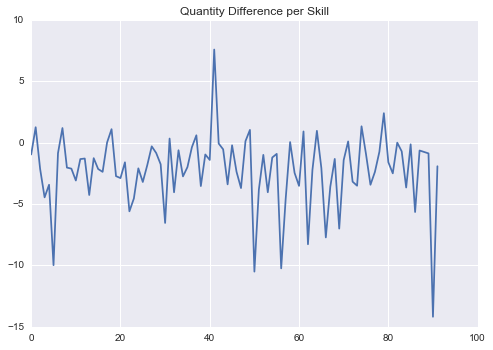

([<matplotlib.lines.Line2D at 0x12a39ceb8>],
 None)

In [67]:
accuracy_comparison['quantity_difference'] = accuracy_comparison.total_y - accuracy_comparison.total_x
plt.plot(accuracy_comparison['quantity_difference']), plt.title("Quantity Difference per Skill"), plt.show()

In [68]:
question_quantity_difference_above_5 = accuracy_comparison[(accuracy_comparison['quantity_difference'] < -5) | (accuracy_comparison['quantity_difference'] > 5)]
question_quantity_difference_above_5

,skill,accuracy_x,total_x,accuracy_y,total_y,diff,quantity_difference
5,5,0.496780,31.770833,0.405745,21.792952,0.091035,-9.977882
22,22,0.644531,14.130435,0.580820,8.537415,0.063711,-5.593020
30,30,0.516271,23.444444,0.480509,16.902439,0.035762,-6.542005
41,41,0.656403,13.765625,0.568396,21.349057,0.088007,7.583432
50,50,0.592836,91.695122,0.488761,81.191860,0.104075,-10.503261
56,56,0.628492,40.893617,0.553621,30.655340,0.074870,-10.238277
62,62,0.541186,51.030612,0.483775,42.756757,0.057411,-8.273855
66,66,0.478269,22.658537,0.395101,14.936893,0.083168,-7.721643
69,69,0.646844,21.662921,0.568707,14.660099,0.078137,-7.002823
86,87,0.637026,22.543210,0.531427,16.891892,0.105600,-5.651318


#### Let's find the top skill outliers

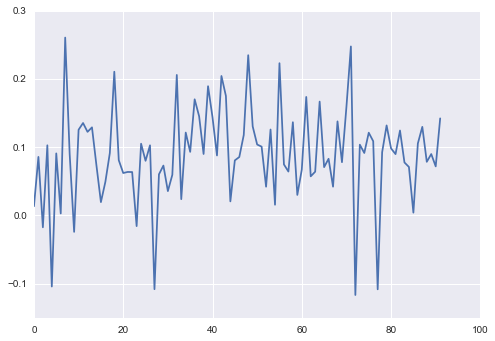

Top contributors: 


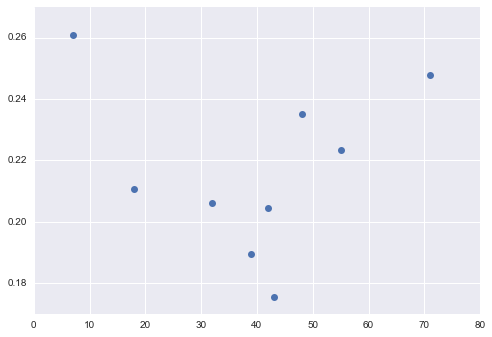

,skill,accuracy_x,total_x,accuracy_y,total_y,diff,quantity_difference
7,7,0.815693,5.200000,0.554830,6.391304,0.260863,1.191304
18,18,0.670296,20.863158,0.459499,21.962264,0.210797,1.099106
32,32,0.591827,26.526316,0.385751,22.483516,0.206077,-4.042799
39,39,0.586022,2.516129,0.396429,1.553571,0.189593,-0.962558
42,42,0.844595,3.216216,0.640027,3.145161,0.204567,-0.071055
43,43,0.485519,12.750000,0.310203,12.205882,0.175316,-0.544118
48,48,1.000000,1.666667,0.764912,1.789474,0.235088,0.122807
55,55,0.765960,9.571429,0.542662,8.658824,0.223299,-0.912605
71,71,0.892857,2.000000,0.645000,2.100000,0.247857,0.100000


In [70]:
plt.plot(accuracy_comparison['diff']), plt.show()
print('Top contributors: ')
above_17_5 = accuracy_comparison[(accuracy_comparison['diff'] > 0.175) | (accuracy_comparison['diff'] < -0.175)]
plt.plot(above_17_5['diff'], 'o'), plt.show()
above_17_5

#### Check if the "top-contributors" are from those with big question_quantity_difference

In [71]:
skills_where_question_quantity_difference_is_above_2 = question_quantity_difference_above_2.skill
risk_zone_skills = 0
for s in skills_where_question_quantity_difference_is_above_2:
    if s in above_17_5.skill:
        print(s)
        risk_zone_skills += 1
if risk_zone_skills == 0:
    print('Nothing Found')

Nothing Found


We may not care about the quantity difference as on average the difference in question taken between the groups is similar

#### Generate The Box Plots per each "Top-Contribution" Skill to see if there is a big overlap

In [72]:
top_contribution_skills = above_17_5.skill
set(top_contribution_skills)

{7, 18, 32, 39, 42, 43, 48, 55, 71}

In [73]:
student_accuracy_with_stem.head()

,itest_id,skill,correct,total,accuracy,isstem
0,35,1,13,19,0.684211,0
1,35,3,1,2,0.500000,0
2,35,4,1,5,0.200000,0
3,35,5,6,19,0.315789,0
4,35,8,1,4,0.250000,0


#### Looking for the optimal minimum quantity of solved questions

In [75]:
for question_threshold in [5, 10, 15, 20, 25]:
    print("================================================")
    print("At least {} questions solved: ".format(question_threshold))
    student_accuracy_with_stem_above_quantity_threshold = student_accuracy_with_stem[student_accuracy_with_stem.total > question_threshold]
    number_of_contributors_left = []
    for i in top_contribution_skills:
        stem_table_filtered_for_box_plot = student_accuracy_with_stem_above_quantity_threshold[(student_accuracy_with_stem_above_quantity_threshold['skill']==i) & (student_accuracy_with_stem['isstem']==1)]
        nonstem_table_filtered_for_box_plot = student_accuracy_with_stem_above_quantity_threshold[(student_accuracy_with_stem_above_quantity_threshold['skill']==i) & (student_accuracy_with_stem['isstem']==0)]
        if stem_table_filtered_for_box_plot.shape[0] == 0 or nonstem_table_filtered_for_box_plot.shape[0] == 0:
            continue
        print("Skill: {}".format(i))
        number_of_contributors_left.append(i)
#         plt.figure(figsize=(12, 2))
#         plt.xlim(xmax=1, xmin=0)
#         sns.boxplot(stem_table_filtered_for_box_plot.accuracy), plt.title("STEM"), plt.show()

#         plt.figure(figsize=(12, 2))
#         plt.xlim(xmax=1, xmin=0)
#         sns.boxplot(nonstem_table_filtered_for_box_plot.accuracy), plt.title("NONSTEM"), plt.show()
    print("Number of Plots {}: {}".format(len(number_of_contributors_left), number_of_contributors_left))

At least 5 questions solved: 
Skill: 7
Skill: 18


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Skill: 32
Skill: 42
Skill: 43
Skill: 55
Number of Plots 6: [7, 18, 32, 42, 43, 55]
At least 10 questions solved: 
Skill: 7
Skill: 18
Skill: 32
Skill: 43
Skill: 55
Number of Plots 5: [7, 18, 32, 43, 55]
At least 15 questions solved: 
Skill: 7
Skill: 18
Skill: 32
Skill: 43
Skill: 55
Number of Plots 5: [7, 18, 32, 43, 55]
At least 20 questions solved: 
Skill: 7
Skill: 18
Skill: 32
Skill: 43
Skill: 55
Number of Plots 5: [7, 18, 32, 43, 55]
At least 25 questions solved: 
Skill: 18
Skill: 32
Skill: 55
Number of Plots 3: [18, 32, 55]


#### Let's test two cases: 4+ and 5+ and 7+ questions

========================== At least 5 questions solved: 
Skill: 7
All: 76; filter Stem: 11; filter NonStem: 20 
 lost: 45 0.5921052631578947


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


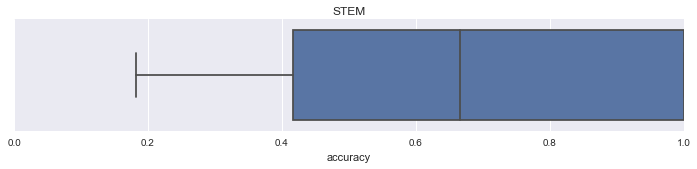

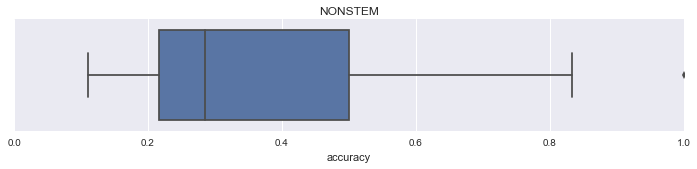

========================== At least 7 questions solved: 
Skill: 7
All: 76; filter Stem: 6; filter NonStem: 12 
 lost: 58 0.7631578947368421


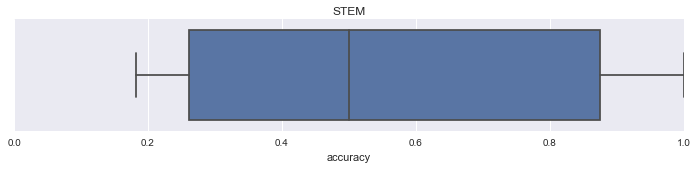

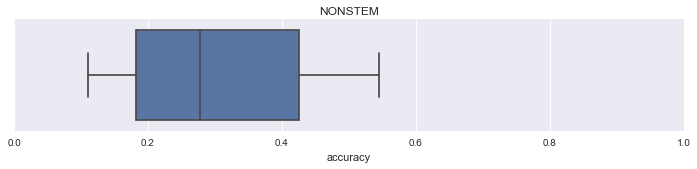

========================== At least 10 questions solved: 
Skill: 7
All: 76; filter Stem: 2; filter NonStem: 7 
 lost: 67 0.881578947368421


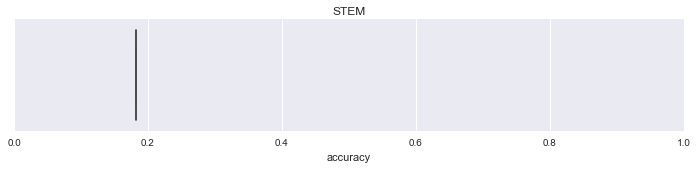

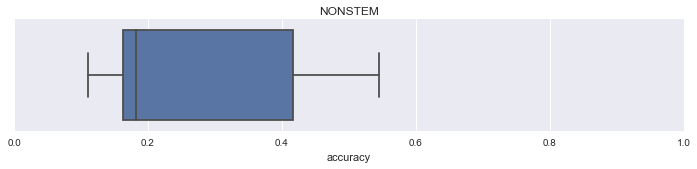

========================== At least 15 questions solved: 
Skill: 7
All: 76; filter Stem: 2; filter NonStem: 3 
 lost: 71 0.9342105263157895


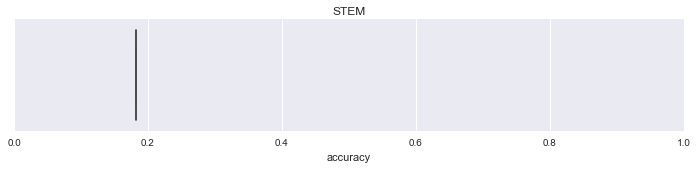

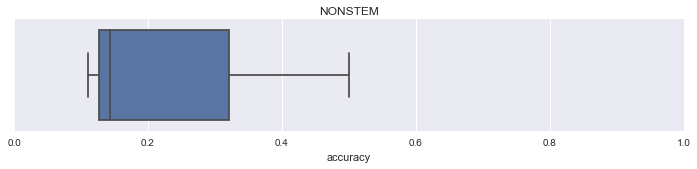

========================== At least 25 questions solved: 
Skill: 7
All: 76; filter Stem: 0; filter NonStem: 1 
 lost: 75 0.9868421052631579
Number of Plots 0: []
========================== At least 5 questions solved: 
Skill: 18
All: 307; filter Stem: 70; filter NonStem: 148 
 lost: 89 0.2899022801302932


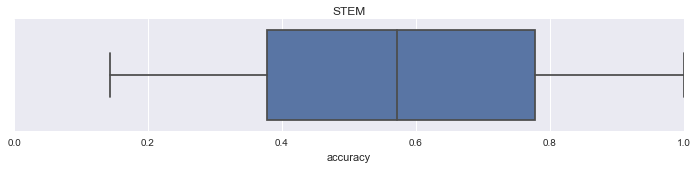

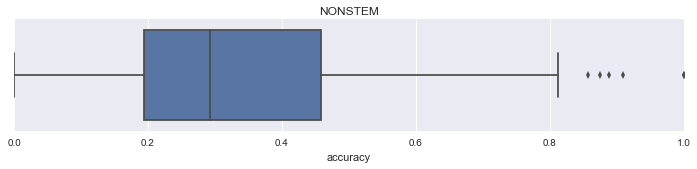

========================== At least 7 questions solved: 
Skill: 18
All: 307; filter Stem: 60; filter NonStem: 126 
 lost: 121 0.3941368078175896


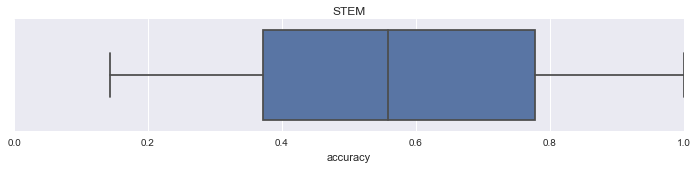

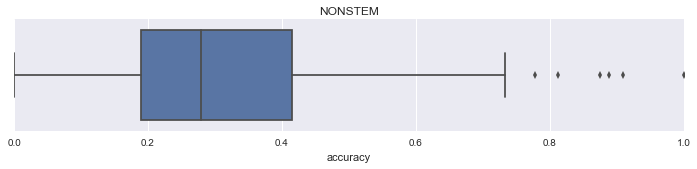

========================== At least 10 questions solved: 
Skill: 18
All: 307; filter Stem: 48; filter NonStem: 103 
 lost: 156 0.50814332247557


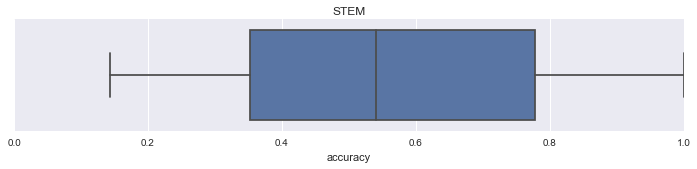

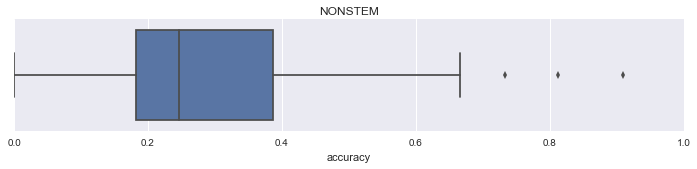

========================== At least 15 questions solved: 
Skill: 18
All: 307; filter Stem: 39; filter NonStem: 80 
 lost: 188 0.6123778501628665


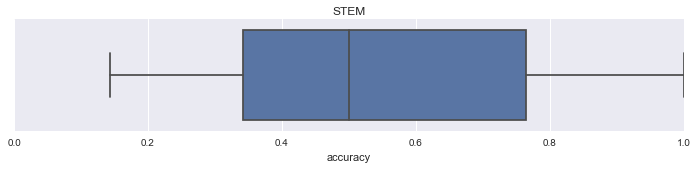

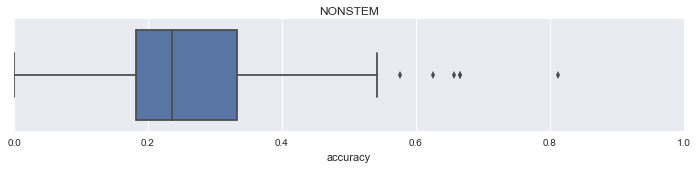

========================== At least 25 questions solved: 
Skill: 18
All: 307; filter Stem: 19; filter NonStem: 55 
 lost: 233 0.758957654723127


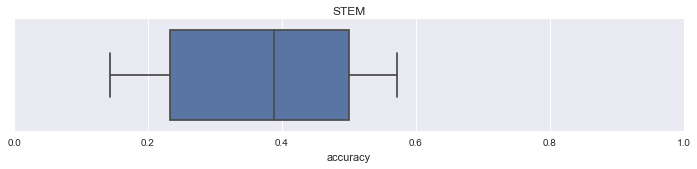

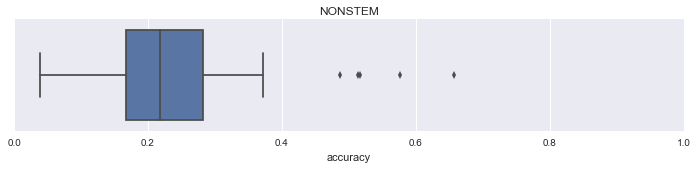

Number of Plots 1: [18]
========================== At least 5 questions solved: 
Skill: 32
All: 129; filter Stem: 29; filter NonStem: 79 
 lost: 21 0.16279069767441862


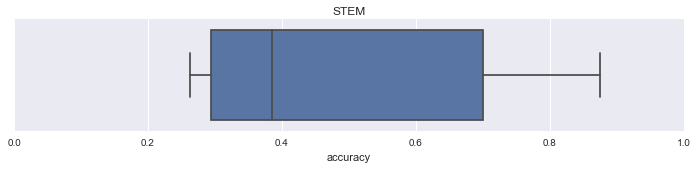

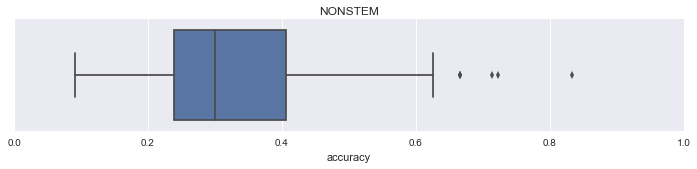

========================== At least 7 questions solved: 
Skill: 32
All: 129; filter Stem: 28; filter NonStem: 72 
 lost: 29 0.2248062015503876


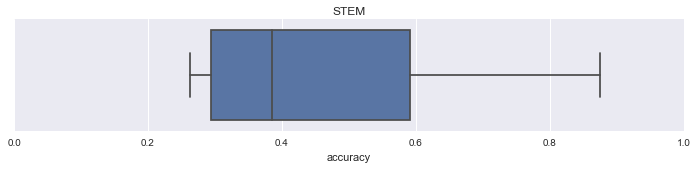

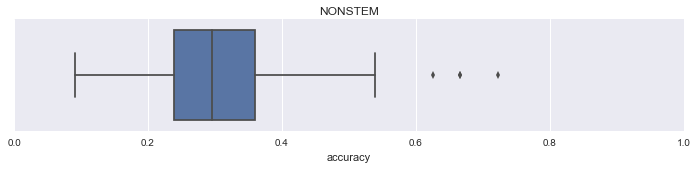

========================== At least 10 questions solved: 
Skill: 32
All: 129; filter Stem: 26; filter NonStem: 67 
 lost: 36 0.27906976744186046


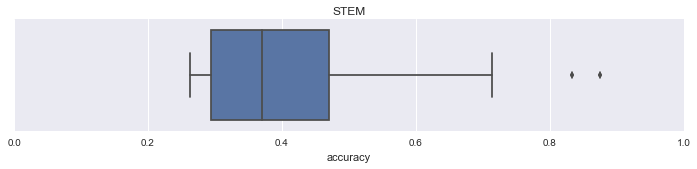

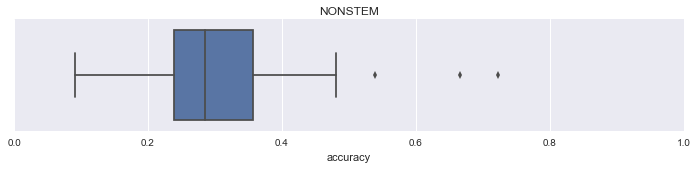

========================== At least 15 questions solved: 
Skill: 32
All: 129; filter Stem: 22; filter NonStem: 55 
 lost: 52 0.40310077519379844


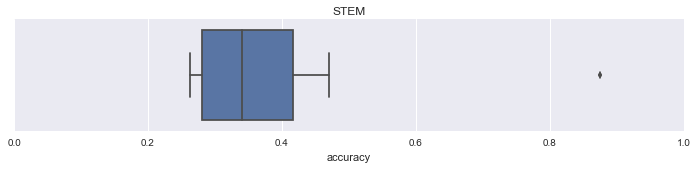

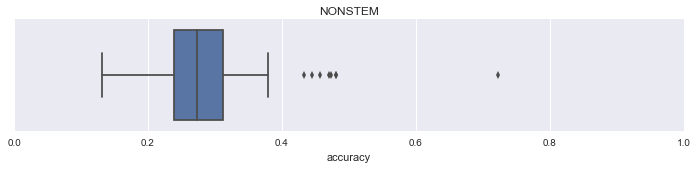

========================== At least 25 questions solved: 
Skill: 32
All: 129; filter Stem: 16; filter NonStem: 35 
 lost: 78 0.6046511627906976


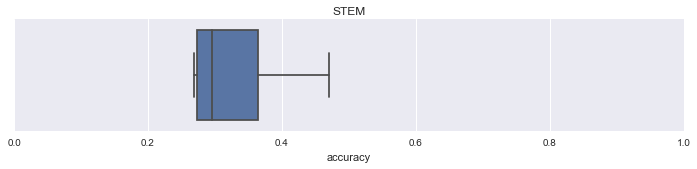

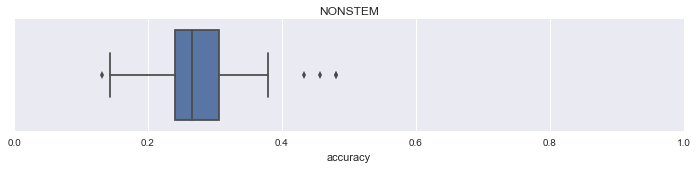

Number of Plots 1: [32]
========================== At least 5 questions solved: 
Skill: 39
All: 87; filter Stem: 2; filter NonStem: 0 
 lost: 85 0.9770114942528736
========================== At least 7 questions solved: 
Skill: 39
All: 87; filter Stem: 0; filter NonStem: 0 
 lost: 87 1.0
========================== At least 10 questions solved: 
Skill: 39
All: 87; filter Stem: 0; filter NonStem: 0 
 lost: 87 1.0
========================== At least 15 questions solved: 
Skill: 39
All: 87; filter Stem: 0; filter NonStem: 0 
 lost: 87 1.0
========================== At least 25 questions solved: 
Skill: 39
All: 87; filter Stem: 0; filter NonStem: 0 
 lost: 87 1.0
Number of Plots 0: []
========================== At least 5 questions solved: 
Skill: 42
All: 99; filter Stem: 4; filter NonStem: 8 
 lost: 87 0.8787878787878788


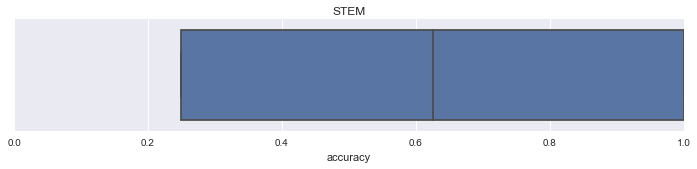

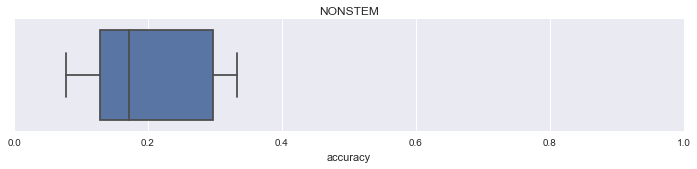

========================== At least 7 questions solved: 
Skill: 42
All: 99; filter Stem: 2; filter NonStem: 4 
 lost: 93 0.9393939393939394


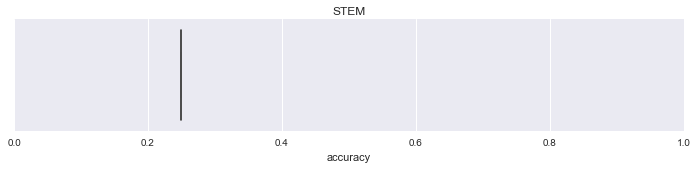

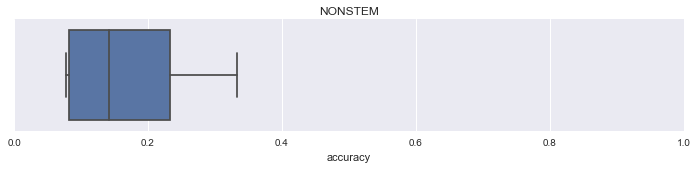

========================== At least 10 questions solved: 
Skill: 42
All: 99; filter Stem: 0; filter NonStem: 2 
 lost: 97 0.9797979797979798
========================== At least 15 questions solved: 
Skill: 42
All: 99; filter Stem: 0; filter NonStem: 0 
 lost: 99 1.0
========================== At least 25 questions solved: 
Skill: 42
All: 99; filter Stem: 0; filter NonStem: 0 
 lost: 99 1.0
Number of Plots 0: []
========================== At least 5 questions solved: 
Skill: 43
All: 46; filter Stem: 9; filter NonStem: 29 
 lost: 8 0.17391304347826086


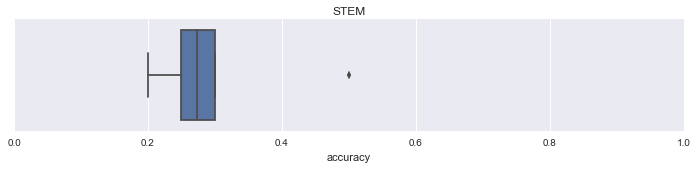

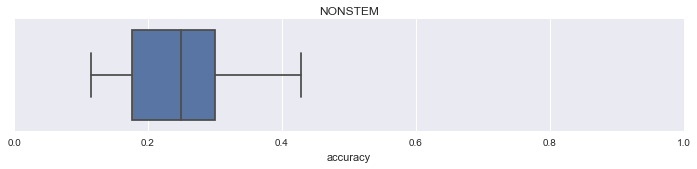

========================== At least 7 questions solved: 
Skill: 43
All: 46; filter Stem: 9; filter NonStem: 28 
 lost: 9 0.1956521739130435


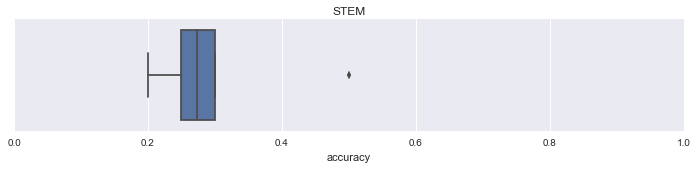

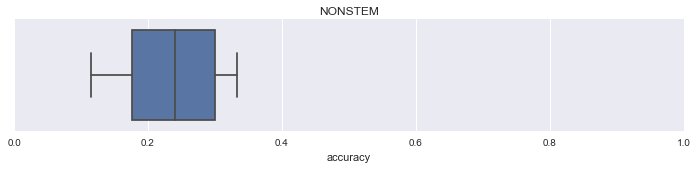

========================== At least 10 questions solved: 
Skill: 43
All: 46; filter Stem: 9; filter NonStem: 17 
 lost: 20 0.43478260869565216


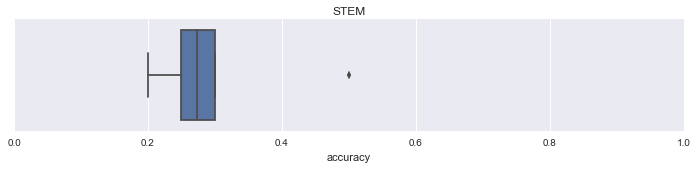

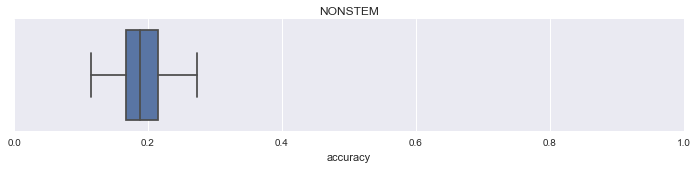

========================== At least 15 questions solved: 
Skill: 43
All: 46; filter Stem: 4; filter NonStem: 9 
 lost: 33 0.717391304347826


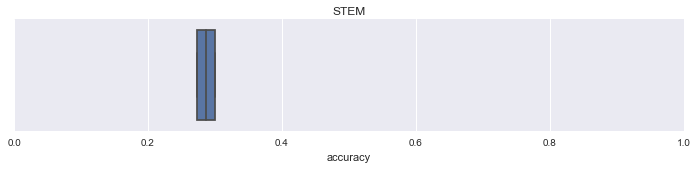

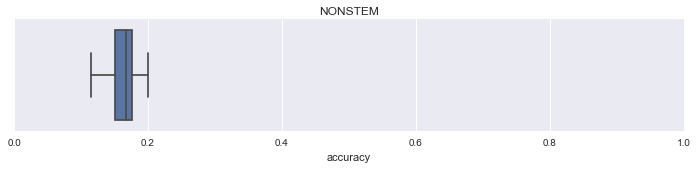

========================== At least 25 questions solved: 
Skill: 43
All: 46; filter Stem: 0; filter NonStem: 1 
 lost: 45 0.9782608695652174
Number of Plots 0: []
========================== At least 5 questions solved: 
Skill: 48
All: 22; filter Stem: 0; filter NonStem: 0 
 lost: 22 1.0
========================== At least 7 questions solved: 
Skill: 48
All: 22; filter Stem: 0; filter NonStem: 0 
 lost: 22 1.0
========================== At least 10 questions solved: 
Skill: 48
All: 22; filter Stem: 0; filter NonStem: 0 
 lost: 22 1.0
========================== At least 15 questions solved: 
Skill: 48
All: 22; filter Stem: 0; filter NonStem: 0 
 lost: 22 1.0
========================== At least 25 questions solved: 
Skill: 48
All: 22; filter Stem: 0; filter NonStem: 0 
 lost: 22 1.0
Number of Plots 0: []
========================== At least 5 questions solved: 
Skill: 55
All: 120; filter Stem: 18; filter NonStem: 44 
 lost: 58 0.48333333333333334


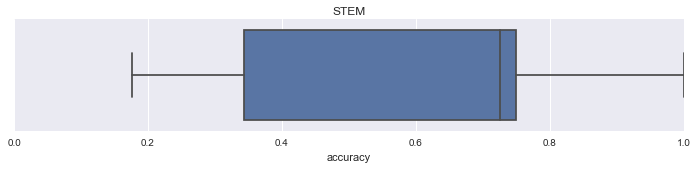

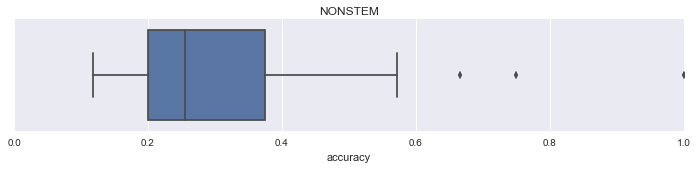

========================== At least 7 questions solved: 
Skill: 55
All: 120; filter Stem: 15; filter NonStem: 38 
 lost: 67 0.5583333333333333


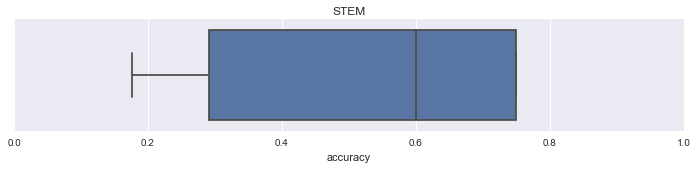

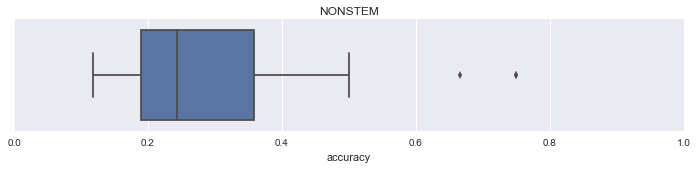

========================== At least 10 questions solved: 
Skill: 55
All: 120; filter Stem: 5; filter NonStem: 31 
 lost: 84 0.7


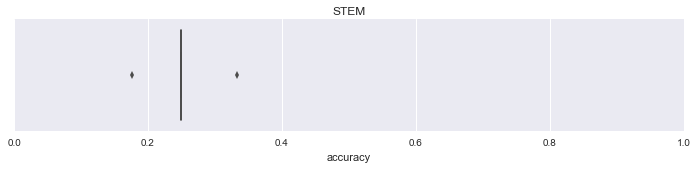

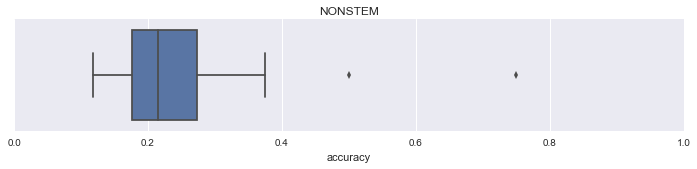

========================== At least 15 questions solved: 
Skill: 55
All: 120; filter Stem: 5; filter NonStem: 16 
 lost: 99 0.825


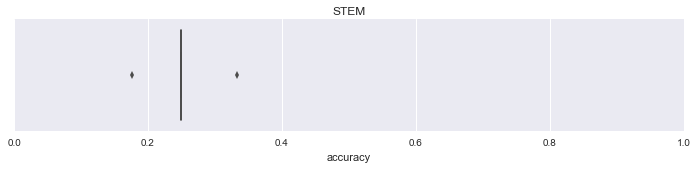

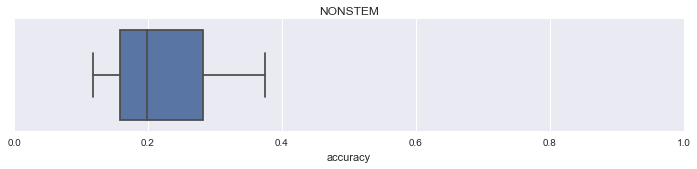

========================== At least 25 questions solved: 
Skill: 55
All: 120; filter Stem: 3; filter NonStem: 2 
 lost: 115 0.9583333333333334


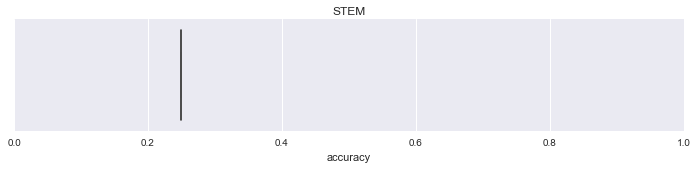

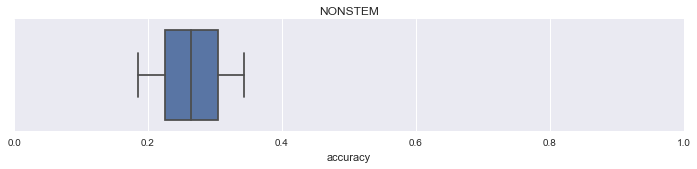

Number of Plots 1: [55]
========================== At least 5 questions solved: 
Skill: 71
All: 18; filter Stem: 1; filter NonStem: 0 
 lost: 17 0.9444444444444444
========================== At least 7 questions solved: 
Skill: 71
All: 18; filter Stem: 0; filter NonStem: 0 
 lost: 18 1.0
========================== At least 10 questions solved: 
Skill: 71
All: 18; filter Stem: 0; filter NonStem: 0 
 lost: 18 1.0
========================== At least 15 questions solved: 
Skill: 71
All: 18; filter Stem: 0; filter NonStem: 0 
 lost: 18 1.0
========================== At least 25 questions solved: 
Skill: 71
All: 18; filter Stem: 0; filter NonStem: 0 
 lost: 18 1.0
Number of Plots 0: []


In [101]:
for i in top_contribution_skills:
    for question_threshold in [5, 7, 10, 15, 25]:
        print("========================== At least {} questions solved: ".format(question_threshold))
        student_accuracy_with_stem_above_quantity_threshold = student_accuracy_with_stem[student_accuracy_with_stem.total > question_threshold]
        number_of_contributors_left = []

        stem_table_filtered_for_box_plot = student_accuracy_with_stem_above_quantity_threshold[(student_accuracy_with_stem_above_quantity_threshold['skill']==i) & (student_accuracy_with_stem['isstem']==1)]
        nonstem_table_filtered_for_box_plot = student_accuracy_with_stem_above_quantity_threshold[(student_accuracy_with_stem_above_quantity_threshold['skill']==i) & (student_accuracy_with_stem['isstem']==0)]
        x = student_accuracy_with_stem[(student_accuracy_with_stem['skill']==i)].shape[0] - stem_table_filtered_for_box_plot.shape[0] - nonstem_table_filtered_for_box_plot.shape[0]
        y = x / student_accuracy_with_stem[(student_accuracy_with_stem['skill']==i)].shape[0]
        print("Skill: {}".format(i))
        print("All: {}; filter Stem: {}; filter NonStem: {} \n lost: {} {}".format(
            student_accuracy_with_stem[(student_accuracy_with_stem['skill']==i)].shape[0], 
            stem_table_filtered_for_box_plot.shape[0], 
            nonstem_table_filtered_for_box_plot.shape[0], x, y))
        if stem_table_filtered_for_box_plot.shape[0] == 0 or nonstem_table_filtered_for_box_plot.shape[0] == 0:
            continue
        
        number_of_contributors_left.append(i)
        plt.figure(figsize=(12, 2))
        plt.xlim(xmax=1, xmin=0)
        sns.boxplot(stem_table_filtered_for_box_plot.accuracy), plt.title("STEM"), plt.show()

        plt.figure(figsize=(12, 2))
        plt.xlim(xmax=1, xmin=0)
        sns.boxplot(nonstem_table_filtered_for_box_plot.accuracy), plt.title("NONSTEM"), plt.show()
    print("Number of Plots {}: {}".format(len(number_of_contributors_left), number_of_contributors_left))

In [79]:
# skill 7 - 5+
# 18 - 10+ or 25
# 32 - 5, 7+, 10
# 43 - 10+
# 55 - 5+

# Look at how many rows are lost

### Compare different quantity threshold correlation

In [234]:
from sklearn.neural_network import MLPClassifier
def extract_feature(row):
    if row.accuracy > decision_boundary:
        return 1
    
def test_svm(df):
    train, test = train_test_split(df, test_size=0.2)
    train_X, train_y = train.iloc[:, 1:], train.iloc[:, 0]
    test_X, test_y = test.iloc[:, 1:], test.iloc[:, 0]
    #w = inv(train_X.T.dot(train_X)).dot(train_X).dot(train_y)
    train_X.shape, train_y.shape, test_X.shape, test_y.shape
    clf = SVC()
    model = clf.fit(train_X, train_y)
    prediction = model.predict(test_X)
    prediction
    comp = prediction == test_y
    return (sum(comp)/len(comp))

def test_mlp(df):
    train, test = train_test_split(df, test_size=0.2)
    train_X, train_y = train.iloc[:, 1:], train.iloc[:, 0]
    test_X, test_y = test.iloc[:, 1:], test.iloc[:, 0]
    #w = inv(train_X.T.dot(train_X)).dot(train_X).dot(train_y)
    train_X.shape, train_y.shape, test_X.shape, test_y.shape
    clf = MLPClassifier()
    model = clf.fit(train_X, train_y)
    prediction = model.predict(test_X)
    prediction
    comp = prediction == test_y
    return (sum(comp)/len(comp))

In [233]:
print('Start', datetime.datetime.now())

for skill_no in [7, 18, 32, 43, 55]:
    print('')
    print("SKILL: {}".format(skill_no))
    for q_th in [5, 7, 10, 15, 25]:
        print('++++++++++++ skill: {}, least questions: {}'.format(skill_no, q_th))
        decision_boundary_acc = []
        decision_boundaries = [0.2, 0.3, 0.4, 0.5, 0.6]
        for decision_boundary in decision_boundaries:
            skill_above_quantity = student_accuracy_with_stem[(student_accuracy_with_stem.skill==skill_no) & (student_accuracy_with_stem.total > q_th)]
            col_name = 'accuracy_s_{}_q_{}_db_{}'.format(skill_no, q_th, decision_boundary)
            skill_above_quantity[col_name] = skill_above_quantity.apply(extract_feature, axis=1)
            final_ds = skill_above_quantity[['itest_id', col_name]]
            final_ds = training[['itest_id', 'isstem']].merge(final_ds, on='itest_id', how='left')
            final_ds = final_ds.drop_duplicates().fillna(0)

            av = []
            repeats = 50
            for i in range(repeats):
                av.append(test_svm(final_ds.iloc[:, 1:]))

            mm = sum(av)/len(av)
            decision_boundary_acc.append(mm)
            print('=============={}'.format(col_name))
            print("average prediction for 10 times", mm)
            print(datetime.datetime.now())
#             plt.ylim(0.5, 1), 
#             plt.plot(av), plt.plot([mm for i in range(repeats)]),
#             plt.show()
        idx = decision_boundary_acc.index(max(decision_boundary_acc))
        print(len(decision_boundaries), len(decision_boundary_acc))
        print("---MAX---", decision_boundaries[idx], decision_boundary_acc[idx])
        print('')


Start 2018-02-15 00:27:42.018663

SKILL: 7
++++++++++++ skill: 7, least questions: 5


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


==============accuracy_s_7_q_5_db_0.2
average prediction for 10 times 0.748510638298
2018-02-15 00:27:42.766163
==============accuracy_s_7_q_5_db_0.3
average prediction for 10 times 0.75085106383
2018-02-15 00:27:43.539650
==============accuracy_s_7_q_5_db_0.4
average prediction for 10 times 0.743617021277
2018-02-15 00:27:44.237206
==============accuracy_s_7_q_5_db_0.5
average prediction for 10 times 0.738936170213
2018-02-15 00:27:44.915922
==============accuracy_s_7_q_5_db_0.6
average prediction for 10 times 0.746595744681
2018-02-15 00:27:45.590469
5 5
---MAX--- 0.3 0.75085106383

++++++++++++ skill: 7, least questions: 7
==============accuracy_s_7_q_7_db_0.2
average prediction for 10 times 0.748510638298
2018-02-15 00:27:46.256457
==============accuracy_s_7_q_7_db_0.3
average prediction for 10 times 0.740425531915
2018-02-15 00:27:46.925872
==============accuracy_s_7_q_7_db_0.4
average prediction for 10 times 0.748085106383
2018-02-15 00:27:47.528406
==============accuracy_s_7_q_7

### All of the features give average result of 75%
To make it less sensitive to questions I will test it with 7 questions threshold






In [280]:
print('Start', datetime.datetime.now())

final_ds = training[['itest_id', 'isstem']]

# for skill_no, q_th, decision_boundary in ((7, 25, 0.3,), (18, 10, 0.2), (32, 10, 0.4), (43, 10, 0.5), (55, 15, 0.6)):
for skill_no, q_th, decision_boundary in ((7, 5, 0.5,), (18, 5, 0.5), (32, 5, 0.5), (43, 5, 0.5), (55, 5, 0.5)):
    print('')
    print("SKILL: {}".format(skill_no))
    print('++++++++++++ skill: {}, least questions: {}'.format(skill_no, q_th))
    decision_boundary_acc = []
    decision_boundaries = [0.2, 0.3, 0.4, 0.5, 0.6]
    skill_above_quantity = student_accuracy_with_stem[(student_accuracy_with_stem.skill==skill_no) & (student_accuracy_with_stem.total > q_th)]
    col_name = 'accuracy_s_{}_q_{}_db_{}'.format(skill_no, q_th, decision_boundary)
    skill_above_quantity[col_name] = skill_above_quantity.apply(extract_feature, axis=1)
    tmp = skill_above_quantity[['itest_id', col_name]]
    final_ds = final_ds.merge(tmp, on='itest_id', how='left')
    final_ds = final_ds.drop_duplicates().fillna(0)

av = []
repeats = 50
for i in range(repeats):
    av.append(test_svm(final_ds.iloc[:, 1:]))

mm = sum(av)/len(av)
decision_boundary_acc.append(mm)
print('=============={}'.format(col_name))
print("average prediction for 10 times", mm)
print(datetime.datetime.now())
#             plt.ylim(0.5, 1), 
#             plt.plot(av), plt.plot([mm for i in range(repeats)]),
#             plt.show()
idx = decision_boundary_acc.index(max(decision_boundary_acc))
print(len(decision_boundaries), len(decision_boundary_acc))
print("---MAX---", decision_boundaries[idx], decision_boundary_acc[idx])
print('')


Start 2018-02-15 00:56:26.878655

SKILL: 7
++++++++++++ skill: 7, least questions: 5


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



SKILL: 18
++++++++++++ skill: 18, least questions: 5

SKILL: 32
++++++++++++ skill: 32, least questions: 5

SKILL: 43
++++++++++++ skill: 43, least questions: 5

SKILL: 55
++++++++++++ skill: 55, least questions: 5
==============accuracy_s_55_q_5_db_0.5
average prediction for 10 times 0.745957446809
2018-02-15 00:56:29.824888
5 1
---MAX--- 0.2 0.745957446809



### Trying to combine all above features to one

In [284]:

# final_ds['combined'] = final_ds.apply()
final_ds['combined'] = final_ds.iloc[:, 2:].sum(axis=1)
final_ds1 = final_ds[['itest_id', 'isstem', 'combined']]

av = []
repeats = 50
for i in range(repeats):
    av.append(test_svm(final_ds1.iloc[:, 1:]))

mm = sum(av)/len(av)
decision_boundary_acc.append(mm)
print('=============={}'.format(col_name))
print("average prediction for 50 times", mm)


==============accuracy_s_55_q_5_db_0.5
average prediction for 50 times 0.745106382979


# Trying only accuracy with no skills  + MLP

In [266]:
# filtering for the necessary col
tmp = actions[['itest_id','correct','actionid']]
# covnverting sk# create a table of correctness by question (from actions_table to problems_table)ills into cat type
tmp['total'] = tmp.actionid.apply(lambda x: 1)
tmp = tmp.drop(['actionid'], axis=1)
tmp.head()

just_accuracy = tmp.groupby(['itest_id'], as_index=False).sum()
just_accuracy['accuracy'] = just_accuracy.correct / just_accuracy.total
just_accuracy = just_accuracy[['itest_id', 'accuracy']].head()
just_accuracy = training[['itest_id', 'isstem']].merge(just_accuracy, on='itest_id', how='left')
just_accuracy = just_accuracy.drop_duplicates().fillna(0)

av = []
repeats = 50
for i in range(repeats):
    av.append(test_mlp(just_accuracy.iloc[:, 1:]))

mm = sum(av)/len(av)
decision_boundary_acc.append(mm)
print('=============={}'.format(col_name))
print("average prediction for 10 times", mm)
print(datetime.datetime.now())
#             plt.ylim(0.5, 1), 
#             plt.plot(av), plt.plot([mm for i in range(repeats)]),
#             plt.show()
idx = decision_boundary_acc.index(max(decision_boundary_acc))
print(len(decision_boundaries), len(decision_boundary_acc))
print("---MAX---", decision_boundaries[idx], decision_boundary_acc[idx])
print('')


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


==============accuracy_s_55_q_5_db_0.5
average prediction for 10 times 0.749574468085
2018-02-15 00:45:07.196622
5 3
---MAX--- 0.3 0.754042553191



,itest_id,isstem,accuracy_s_7_q_5_db_0.5,accuracy_s_18_q_5_db_0.5,accuracy_s_32_q_5_db_0.5,accuracy_s_43_q_5_db_0.5,accuracy_s_55_q_5_db_0.5
0,9,1,0.0,0.0,0.0,0,0.0
1,27,0,0.0,0.0,0.0,0,0.0
2,33,0,0.0,0.0,0.0,0,0.0
3,35,0,0.0,0.0,0.0,0,0.0
4,37,0,0.0,0.0,0.0,0,0.0
